# Consistent scores

A "consistent scoring function" is a scoring function where a forecaster's expected score will be optimised by following a forecast directive (e.g., forecast the 90th percentile value). It is important to use consistent scoring functions to avoid the "forecaster's dilemma" ([Lerch et al., 2017](https://projecteuclid.org/journals/statistical-science/volume-32/issue-1/Forecasters-Dilemma-Extreme-Events-and-Forecast-Evaluation/10.1214/16-STS588.full)) (i.e., should a forecaster issue an honest forecast or should they issue one that optimises their expected score?). Consistent scoring functions are formally defined in([Gneiting et al., 2011](https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.r10138)).


The Mean Squared Error (MSE) is a consistent score for forecasting the mean and the Mean Absolute Error (MAE) is a consistent score for forecasting the median. But did you know that there are a whole family of scores that are consistent for prediciting the mean, median, or quantiles? 

The consistent scoring module in `scores` provides access to these families of consistent scores that can be used to emphasise predictive performance across desired decision thresholds.

### Example 1. A score consistent with the mean
Let's jump into an example that illustrates a scoring function that is consistent with predicting the mean value using `scores`. Suppose we want to evaluate the performance of expected daily precipitation forecasts, but we want to place increasing importance on correctly forecasting extreme values. 


We want to used the `consistent_expectile_score` in `scores` to evaluate the expected daily precipitation forecasts. Note that medians relate to quantiles in an analogous way to how the mean relates to [expectiles](https://en.wikipedia.org/wiki/Expectile).

Our consistent scoring function for expectiles is 

 $$ S(x, y) =
    \begin{cases}
    (1 - \alpha)(\phi(y) - \phi(x) - \phi'(x)(y-x)), & y < x \\
    \alpha(\phi(y) - \phi(x) - \phi'(x)(y-x)), & x \leq y
    \end{cases}
$$

Where:
- $x$ is the forecast
- $y$ is the observation
- $\alpha$ is the expectile level
- $\phi$ is a [convex function](https://en.wikipedia.org/wiki/Convex_function) of a single variable
- $\phi'$ is the [subderivative](https://en.wikipedia.org/wiki/Subderivative) of $\phi$. The subderivative is a generalisation of the derivative for convex functions and coincides with the derivative when the convex function is differentiable
- $S(x,y)$ is the score.

To make the expectile the consistent with the mean, set $\alpha=0.5$.

Next we need to determine our $\phi(z)$ and $\phi'(z)$ functions. Let's assume that that the importance of predicting extreme rainfall increases exponentially.

First we create the weighting function

$$\phi''(z) = e^\frac{z}{10}$$ 

This will place increasing importance on more extreme rainfall thresholds. We will plot this weighting function further below.

Next we need to integrate $\phi''(z)$ twice so that we can derive the functions for our consistent scoring function

$$\phi'(z) = 10e^\frac{z}{10}$$ 
and 
$$\phi(z) = z + 100e^\frac{z}{10}$$ 

These equations with $\alpha=0.5$ can be substituted into $ S(x, y)$ to create our consistent scoring function

$$
S(x,y) = \frac{1}{2}(y + 100e^\frac{y}{10} - x + 100e^\frac{x}{10} - (10e^\frac{x}{10})(y-x))
$$

Note that to use the `consistent_expectile_score` in scores, you only need to define $\phi(z)$ and $\phi'(z)$, but not $S(x, y)$.



Let's illustrate how this can be done in scores using some synthetic rainfall data.

In [1]:
from scores.continuous import consistent_expectile_score, consistent_quantile_score, mse, murphy_score, murphy_thetas
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
import numpy as np
import xarray as xr

np.random.seed(100)

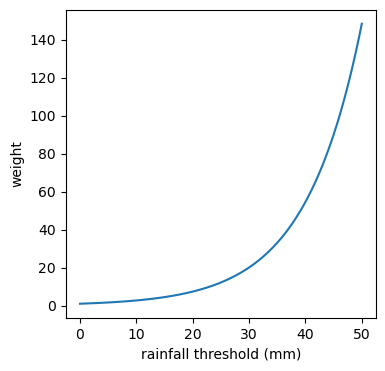

In [2]:
# First, let's visualise our weighting function phi''
# Higher weights mean that there is a higher importance place on forecasting values around
# those decision thresholds in the scoring function
x = np.linspace(0, 50, 1000)
y = np.exp(x / 10)

plt.figure(figsize=(4, 4))
plt.plot(x, y)
plt.xlabel("rainfall threshold (mm)")
plt.ylabel("weight")
plt.show()

In [3]:
# define phi and phi prime
def phi_prime(z):
    """Phi prime"""
    return 10 * np.exp(z / 10)


def phi(z):
    """Phi"""
    return z + 100 * np.exp(z / 10)

In [4]:
# Generate some synthetic rainfall observations between 0 and 50mm
N = 1000
obs = xr.DataArray(data=50 * np.random.random(N), dims=["time"], coords={"time": np.arange(0, N)})
obs = obs.clip(min=0)  # don't allow negative rainfall

# Generate synthetic forecasts by adding noise to each observation
fcst1 = 0.9 * obs + skewnorm.rvs(4, size=N)  # fcst1 has a low bias
fcst1 = fcst1.clip(min=0)  # don't allow negative rainfall
fcst2 = 1.1 * obs - skewnorm.rvs(4, size=N)  # fcst2 has a high bias
fcst2 = fcst2.clip(min=0)  # don't allow negative rainfall

In [5]:
# First if we calculate the MSE of fcst1 and fcst2 we will see that that have similar predictive performance.
print(f"fcst1 MSE = {mse(fcst1, obs).item()}")
print(f"fcst2 MSE = {mse(fcst2, obs).item()}")

fcst1 MSE = 5.458075056770564
fcst2 MSE = 5.453055339632795


In [6]:
# However, when we calculate the performance of these forecasts with increasing focus on
# extreme decision thresholds, we see that the performance is quite different.
fcst1_cons_score = consistent_expectile_score(fcst1, obs, alpha=0.5, phi=phi, phi_prime=phi_prime).item()
fcst2_cons_score = consistent_expectile_score(fcst2, obs, alpha=0.5, phi=phi, phi_prime=phi_prime).item()

print(f"fcst1 consistent score = {fcst1_cons_score}")
print(f"fcst2 consistent score = {fcst2_cons_score}")

fcst1 consistent score = 66.17672988766219
fcst2 consistent score = 107.20979750404182


Why is this? To visualise the difference in performance, we use plot Murphy Diagrams. See the [Murphy Diagrams tutorial](./Murphy_Diagrams.ipynb).

Text(0.5, 0.98, 'Murphy Score (for mean)')

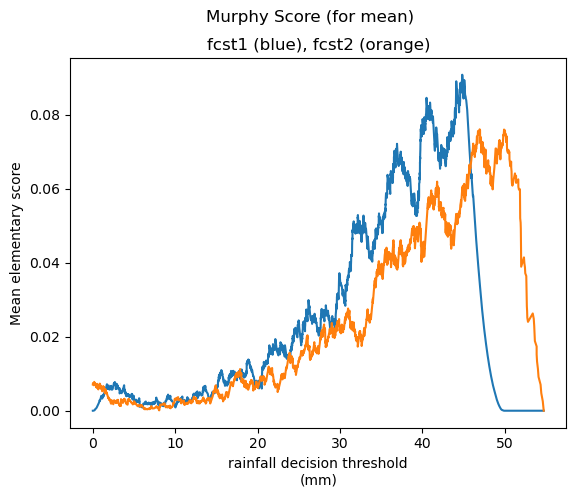

In [7]:
# Generate a list of thresholds of interest
thetas = murphy_thetas([fcst1, fcst2], obs, "expectile")

# Calculate the average elementary score for the mean (0.5 expectile) for each threshold theta
ms1 = murphy_score(fcst1, obs, thetas, functional="expectile", alpha=0.5)
ms2 = murphy_score(fcst2, obs, thetas, functional="expectile", alpha=0.5)

# Rename date variable for plotting
ms1 = ms1.rename({"total": "Mean elementary score", "theta": "rainfall decision threshold (mm)"})
ms2 = ms2.rename({"total": "Mean elementary score", "theta": "rainfall decision threshold (mm)"})

# Plot the results
ms1["Mean elementary score"].plot()
ms2["Mean elementary score"].plot()
plt.title("fcst1 (blue), fcst2 (orange)")
plt.suptitle("Murphy Score (for mean)")

Lower values are better on the Murphy Diagram. Fcst2 (orange) performs far worse at higher rainfall thresholds, so is penalised more heavily due to out weighting function $\phi''(z) = \exp ^\frac{z}{10}$.

### Example 2. A score consistent with a quantile

Suppose we have a 90th percentile wind speed forecast that we want to evaluate, emphasising performance for higher thresholds. We can use the `consistent_quantile_score` in `scores`.

Our consistent quantile score is defined as

$$ S(x, y) = \begin{cases}(1 - \alpha)(g(x) - g(y)), & y < x \\\alpha(g(y) - g(x)), & x \leq y\end{cases}$$

where:

- $x$ is the forecast
- $y$ is the observation
- $\alpha$ is the quantile level
- $g$ is a nondecreasing function of a single variable
- $S(x,y)$ is the score.

Now suppose we want to emphasise the performance for higher thresholds, but we don't want our weights to increase exponentially like in rainfall example above. We first define our weighting function as 

$$g'(z)= \frac{-1}{(z+10)}+0.5$$

Let's visualise our weighting function

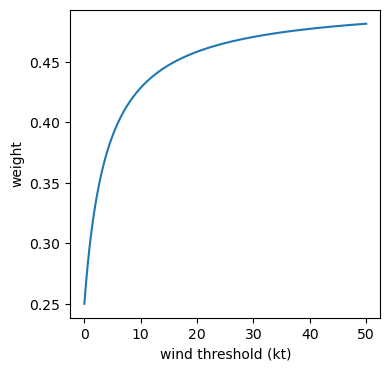

In [8]:
x = np.linspace(0, 50, 1000)
y = -1 / (x + 4) + 0.5

plt.figure(figsize=(4, 4))
plt.plot(x, y)
plt.xlabel("wind threshold (kt)")
plt.ylabel("weight")
plt.show()

We need to derive $g$ for our `consistent_quantile_score` by integrating $g'$

$$g(z) = 0.5z - ln(z+4)$$

To evaluate the 90th percentile forecast, we need to set $\alpha=0.9$. Now we can use the `consistent_quantile_score`.

In [9]:
def g(z):
    """g(z) for our conistent score"""
    return 0.5 * z - np.log(z + 4)

In [10]:
# Let's assume that the synthetic rainfall data that we created before is now synthetic
# wind speed data
fcst1_cons_quant_score = consistent_quantile_score(fcst1, obs, alpha=0.9, g=g).item()
fcst2_cons_quant_score = consistent_quantile_score(fcst2, obs, alpha=0.9, g=g).item()

print(f"fcst1 consistent quantile score = {fcst1_cons_quant_score}")
print(f"fcst2 consistent quantile score = {fcst2_cons_quant_score}")

fcst1 consistent quantile score = 0.7739176898842436
fcst2 consistent quantile score = 0.11712102469880409


In this case, fcst2 performs better. This is because it has an overforecast bias for a mean forecast, but it performs better than fcst1 as a 90th percentile forecast. Let's visualise this on a Murphy Diagram that shows the performance for 90th percentile forecasts across each decision threshold.

Text(0.5, 0.98, 'Murphy Score (for 90th percentile)')

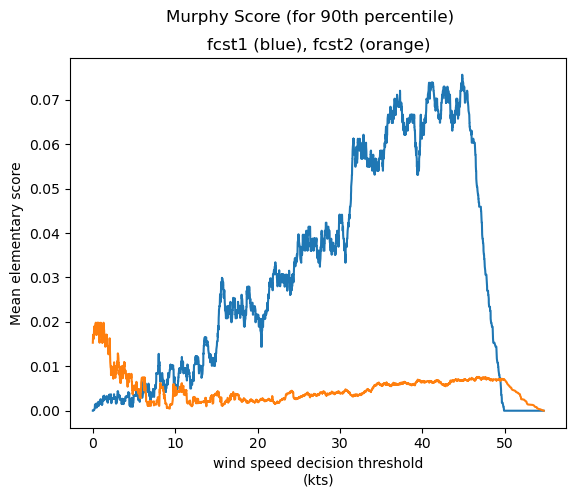

In [11]:
# Generate a list of thresholds of interest
thetas = murphy_thetas([fcst1, fcst2], obs, "quantile")

ms1 = murphy_score(fcst1, obs, thetas, functional="quantile", alpha=0.9)
ms2 = murphy_score(fcst2, obs, thetas, functional="quantile", alpha=0.9)

# Rename date variable for plotting
ms1 = ms1.rename({"total": "Mean elementary score", "theta": "wind speed decision threshold (kts)"})
ms2 = ms2.rename({"total": "Mean elementary score", "theta": "wind speed decision threshold (kts)"})

# Plot the results
ms1["Mean elementary score"].plot()
ms2["Mean elementary score"].plot()
plt.title("fcst1 (blue), fcst2 (orange)")
plt.suptitle("Murphy Score (for 90th percentile)")

What we can see is that fcst2 (orange) performs best for most decision thresholds. Despite weighting higher wind speed thresholds more heavily and fcst2 performing worse for thresholds above 50kt, fcst2 still scored better because it performed substantially better for many decision thresholds and the weights did not exponentially increase.

## Things to try next.

- Test out different weighting functions. 
- Try out `consistent_huber_score`. This uses $\phi$ and $\phi'$ like `consistent_expectile_score`, but also takes a huber parameter.

## Further reading
- [Gneiting, T., 2011. Making and evaluating point forecasts. Journal of the American Statistical Association, 106(494), pp.746-762.](https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.r10138)
- [Taggart, R., 2022. Evaluation of point forecasts for extreme events using consistent scoring functions. Quarterly Journal of the Royal Meteorological Society, 148(742), pp.306-320.](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.4206)
- [Taggart, R.J., 2022. Point forecasting and forecast evaluation with generalized Huber loss. Electronic Journal of Statistics, 16(1), pp.201-231.](https://projecteuclid.org/journals/electronic-journal-of-statistics/volume-16/issue-1/Point-forecasting-and-forecast-evaluation-with-generalized-Huber-loss/10.1214/21-EJS1957.full)